In [1]:
import os
from sklearn.datasets import fetch_openml
home_dir = os.getcwd();
mnist = fetch_openml('mnist_784', data_home=os.path.join(home_dir, 'scikit_learn_data'))
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

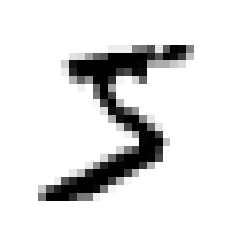

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
image = X[0]
re_im = image.reshape(28, 28)
plt.imshow(re_im, cmap='binary')
plt.axis('off')
plt.show()

In [5]:
y[0]

'5'

In [6]:
import numpy as np
y = y.astype(np.uint8)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier
sgd_cls = SGDClassifier(random_state=42)
sgd_cls.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_cls.predict([image])

array([ True])

In [11]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5): 
    clone_clf = clone(sgd_cls)
    
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index] 
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) 

0.9669
0.91625
0.96785


In [12]:
from sklearn.model_selection import cross_val_score
val_score = cross_val_score(sgd_cls, X_train, y_train_5, scoring='accuracy', cv=5)
val_score

array([0.95466667, 0.96975   , 0.9635    , 0.96533333, 0.94841667])

In [13]:
from sklearn.base import BaseEstimator

class Is_5(BaseEstimator):
    def fit(self, X, y):
        return self;
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
is_5 = Is_5()
cross_val_score(is_5, X_train, y_train_5, scoring='accuracy', cv=3)

array([0.91125, 0.90855, 0.90915])

In [14]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_cls, X_train, y_train_5, cv=3)


In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [16]:
from sklearn.metrics import precision_score, recall_score
prec = precision_score(y_train_5, y_train_pred)
prec

0.8370879772350012

In [17]:
rec = recall_score(y_train_5, y_train_pred)
rec

0.6511713705958311

In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [19]:
y_score = sgd_cls.decision_function([image])
y_score

array([2164.22030239])

In [20]:
threshold = 0;
y_decision_pred = (y_score > threshold)
y_decision_pred

array([ True])

In [21]:
y_scores = cross_val_predict(sgd_cls, X_train, y_train_5, cv=3, method='decision_function')

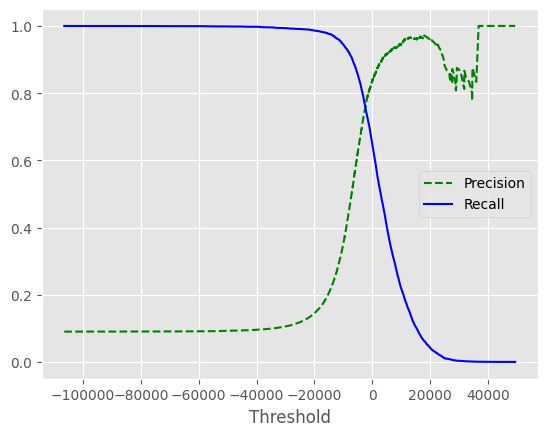

<Figure size 1200x900 with 0 Axes>

In [50]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_vs_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], linestyle='dashed', color='green', label='Precision')
    plt.plot(thresholds, recalls[:-1], linestyle='solid', color='blue', label='Recall')
    plt.legend(loc='best')
    plt.grid(True)
    plt.xlabel('Threshold')
    plt.figure(figsize=(12,9))
    
plt.style.use('ggplot')
plot_precision_vs_recall(precisions, recalls, thresholds)

In [26]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [29]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

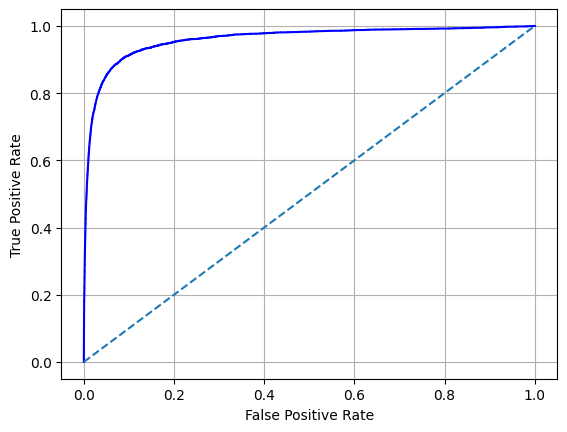

In [57]:
from sklearn.metrics import roc_curve
tpr, fpr, threshold = roc_curve(y_train_5, y_scores)

def tpr_fpr_curve(tpr, fpr, label=None):
    plt.plot(tpr, fpr, linestyle='solid', color='blue', label=label)
    plt.plot([0, 1], [0, 1], linestyle='dashed')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
plt.style.use('default')
tpr_fpr_curve(tpr,fpr)
plt.show()

In [55]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [63]:
from sklearn.ensemble import RandomForestClassifier

ran_forest_cls = RandomForestClassifier(random_state=42)
y_forest_probas = cross_val_predict(ran_forest_cls, X_train, y_train_5, method='predict_proba', cv=3)
y_forest_scores = y_forest_probas[:, 1]
forest_tpr, forest_fpr, threshold = roc_curve(y_train_5, y_forest_scores)

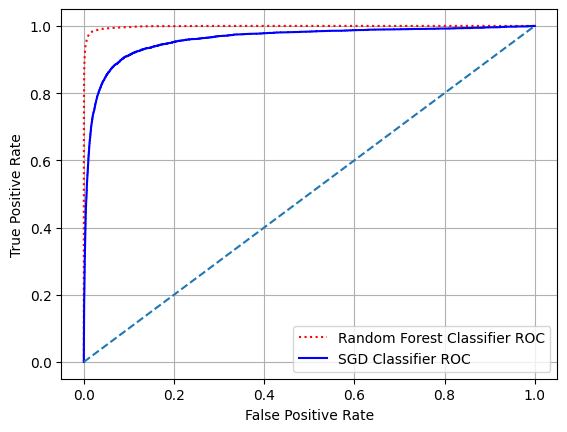

In [60]:
plt.plot(forest_tpr, forest_fpr, linestyle='dotted', color='red', label='Random Forest Classifier ROC')
tpr_fpr_curve(tpr, fpr, 'SGD Classifier ROC')
plt.legend(loc='best')
plt.show()

In [62]:
roc_auc_score(y_train_5, y_forest_scores)

0.9983436731328145

In [68]:
from sklearn.svm import SVC
svm_cls = SVC()
svm_cls.fit(X_train, y_train)
svm_cls.predict([image])

array([5], dtype=uint8)

In [69]:
svm_scores = svm_cls.decision_function([image])
svm_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [74]:
index = np.argmax(svm_scores)
svm_cls.classes_[index]

5

In [77]:
from sklearn.multiclass import OneVsRestClassifier
ovr_cls = OneVsRestClassifier(SVC())
ovr_cls.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [78]:
ovr_cls.predict([image])

array([5], dtype=uint8)

In [81]:
sgd_cls.fit(X_train, y_train)
sgd_cls.predict([image])

array([3], dtype=uint8)

In [82]:
sgd_cls.decision_function([image])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [87]:
from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_cls, X_train_scaled, y_train, scoring='accuracy', cv=3)

array([0.8983, 0.891 , 0.9018])

In [89]:
y_train_pred = cross_val_predict(sgd_cls, X_train_scaled, y_train, cv=3)
conf_mtx = confusion_matrix(y_train, y_train_pred)
conf_mtx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

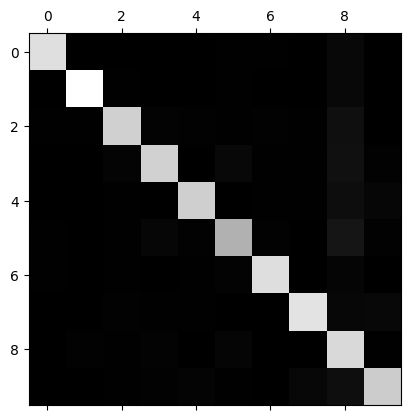

In [90]:
plt.matshow(conf_mtx, cmap='gray')

In [98]:
row_sums = conf_mtx.sum(axis=1, keepdims=True) 
norm_conf_mx = conf_mtx / row_sums

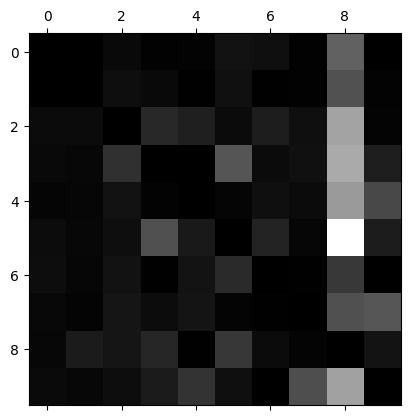

In [97]:
np.fill_diagonal(norm_conf_mx, 0) 
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

In [100]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

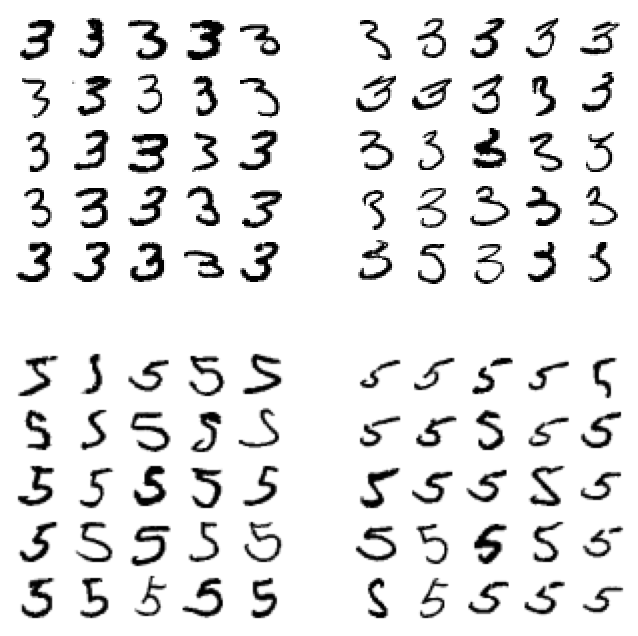

In [103]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] 
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] 
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] 
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5) 
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5) 
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

In [106]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

kn_cls = KNeighborsClassifier()
kn_cls.fit(X_train_scaled, y_multilabel)

KNeighborsClassifier()

In [107]:
kn_cls.predict([image])

array([[False,  True]])

In [110]:
y_train_pred_scores = cross_val_predict(kn_cls, X_train_scaled, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_pred_scores, average='macro')

0.9613989329409902

In [111]:
noise = np.random.randint(0, 100, (len(X_train), 784)) 
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784)) 
X_test_mod = X_test + noise
y_train_mod = X_train 
y_test_mod = X_test

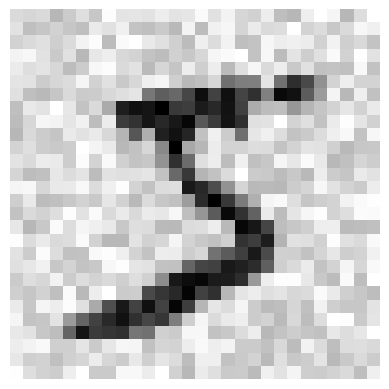

In [114]:
plot_digits(X_train_mod[:1])

In [115]:
kn_cls.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

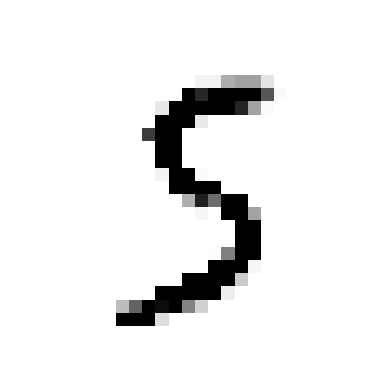

In [117]:
clean_digit = kn_cls.predict(X_train_mod[:1])
plot_digits(clean_digit)